#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Количество заказов находится в столбце `num_orders`.

## Подготовка

Импортируем необходимые библиотеки и инструменты

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

Загрузим данные и ознакомимся с ними

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков в данных нет

Перезагрузим данные, преобразовав столбец с датами в формат дат и сделав его индексами

In [5]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Отсортируем данные по датам в порядке возрастания

In [6]:
df.sort_index(inplace=True)

Выполним ресемплирование по одному часу

In [7]:
df = df.resample('1H').sum()

Посмотрим, что получилось

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Посмотрим статистические характеристики данных

In [10]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Посмотрим до какой даты наши данные

In [11]:
df.index.max()

Timestamp('2018-08-31 23:00:00')

Мы имеем данные с 1 марта 2018 года по 31 августа 2018 года

Построим гистограмму распределения по количеству заказов в час

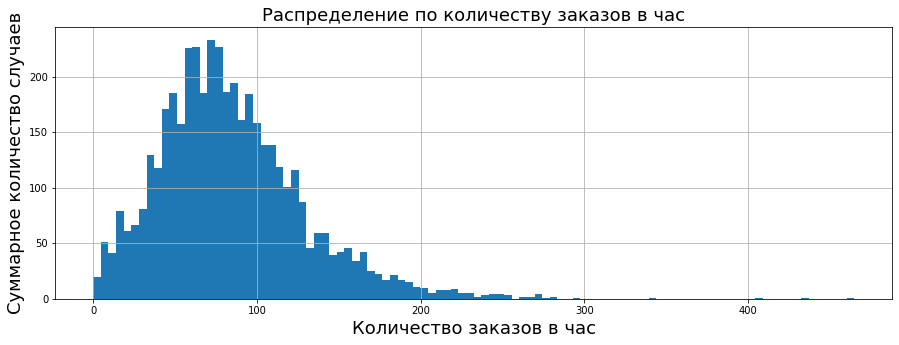

In [12]:
plt.figure(figsize=(15,5))

plt.title('Распределение по количеству заказов в час', fontsize=18)
    
plt.ylabel('Суммарное количество случаев', fontsize=18)
    
plt.xlabel('Количество заказов в час', fontsize=18)

df['num_orders'].hist(bins=100, range = (0, 465), figsize = (15, 5))

plt.show()

Распределение близко к нормальному и имеет небольшой хвост

Выполним декомпозицию данных для построения тренда и сезонности

In [13]:
decomposed = seasonal_decompose(df)

Создадим функцию для построения графиков

In [14]:
def data_plot(data, title, ylabel, xlabel):
    
    '''
    Функция для построения графиков
    
    '''
    data.plot(kind='line', figsize = (15, 5), rot=0, grid=True)

    plt.title(title, fontsize=18)

    plt.ylabel(ylabel, fontsize=18)

    plt.xlabel(xlabel, fontsize=18)

    plt.show()

Построим график тренда

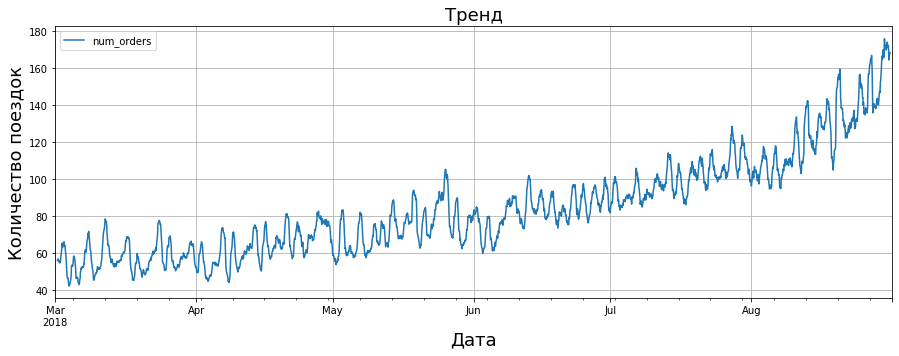

In [15]:
data_plot(decomposed.trend, 'Тренд', 'Количество поездок', 'Дата')

Видим, что услугами такси пользуются всё больше

Посмотрим на сезонность

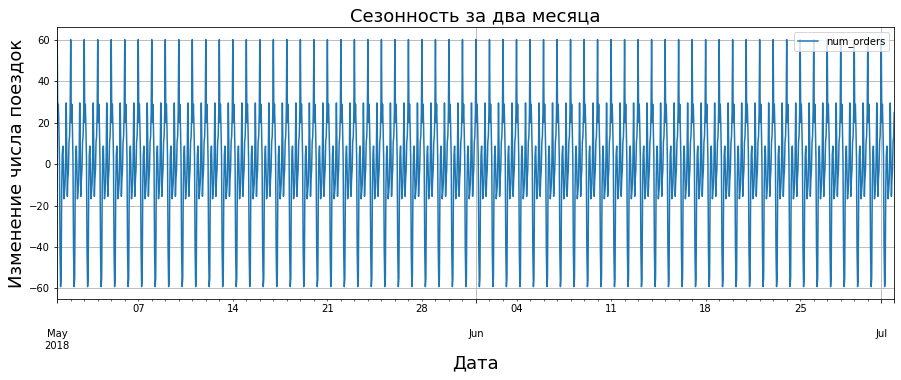

In [16]:
data_plot(decomposed.seasonal['2018-05-01':'2018-07-01'], 'Сезонность за два месяца', 'Изменение числа поездок', 'Дата')

Видим, что сезонность суточная. Посмотрим на неё

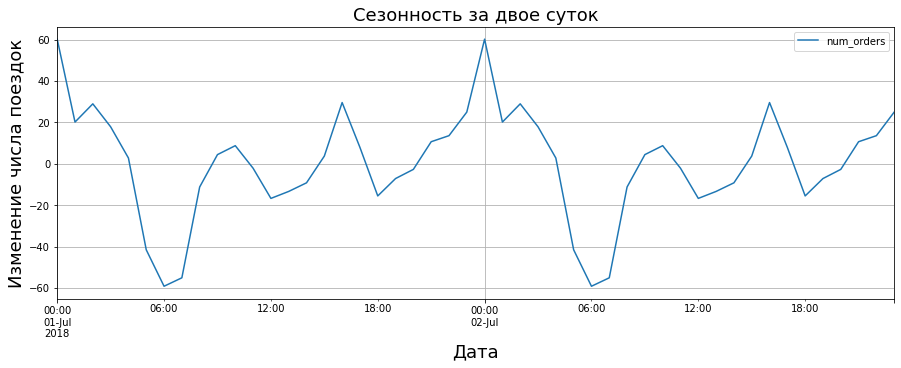

In [17]:
data_plot(decomposed.seasonal['2018-07-01':'2018-07-02'], 'Сезонность за двое суток', 'Изменение числа поездок', 'Дата')

## Обучение

Создадим функцию для дополнения данных новыми признаками: месяцем, днём, днём недели, часом, отстающими данными и скользящим средним 

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    
    '''
    Функция для дополнения данных новыми признаками
    
    '''
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Воспользуемся функцией дополнения данных с количеством опаздывающих данных 6 и скользящим средним за 6 часов 

In [19]:
make_features(df, 12, 6) # В зданном варианте было 6 и 6

In [20]:
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сбросим индексы для дальнейшей работы

In [21]:
df = df.reset_index(drop=True)

Разделим данные на обучающую (90%) и тестовую (10%) выборки (параметр `shuffle=False`, т.к. нельзя перемешивать временные данные в данном проекте). Удалим строки с пропусками из обучающей выборки 

In [22]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

train = train.dropna().reset_index(drop=True)

Сохраним признаки и целевой признак для обучающей и тестовой выборок

In [23]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Создадим функцию для расчёта RMSE

In [24]:
def rmse(target, predicted):
    
    '''
    Функция для расчёта RMSE
    
    '''
    
    mse = mean_squared_error(target, predicted)
    
    rmse = round(mse ** 0.5)
    
    return rmse

Обучим модель линейной регрессии и получим её предсказания для обучающей выборки

In [25]:
lr = LinearRegression()

lr.fit(features_train, target_train)

predictions_train_lr = lr.predict(features_train)

Посчитаем RMSE модели для обучающей выборки

In [26]:
rmse_train_lr = rmse(target_train, predictions_train_lr)

rmse_train_lr

30

Создадим функцию для подбора лучших гиперпараметров по метрике MSE на основе GridSearchCV (параметр `cv=TimeSeriesSplit()`, т.к. мы имеем дело с временными рядами)

In [27]:
def best_model(model, features, target, param_grid):
    
    '''
    Функция для подбора лучших гиперпараметров модели
    
    '''
    
    reg = model(random_state=12345)
    
    grid_search = GridSearchCV(reg, param_grid, cv=TimeSeriesSplit(n_splits=10), scoring='neg_mean_squared_error')
    
    grid_search.fit(features, target)
    
    best_params = grid_search.best_params_
    
    best_score = grid_search.best_score_
    
    return best_params, best_score

Подберём гиперпараметры для модели случайного леса

In [28]:
param_grid = {'n_estimators': [4, 8, 12], 'max_depth': [4, 8, 12]}

In [29]:
best_params_rf, best_score_rf = best_model(RandomForestRegressor, features_train, target_train, param_grid)
print('Лучшие гиперпараметры:', best_params_rf)
print('Лучшая RMSE:', (-best_score_rf)**0.5)

Лучшие гиперпараметры: {'max_depth': 12, 'n_estimators': 12}
Лучшая RMSE: 25.053315719089497


Применим модель случайного леса с лучшими гиперпараметрами

In [30]:
rf = RandomForestRegressor(random_state=12345, n_estimators=best_params_rf['n_estimators'], 
                               max_depth=best_params_rf['max_depth'])

Обучим модель на обучающей выборке и получим для неё предсказания

In [31]:
rf.fit(features_train, target_train)

predictions_train_rf = rf.predict(features_train)

Рассчитаем RMSE

In [32]:
rmse_train_rf = rmse(target_train, predictions_train_rf)

rmse_train_rf

13

Подберём гиперпараметры для модели CatBoost

In [33]:
categorical = ['month', 'day', 'dayofweek']

In [34]:
cbr = CatBoostRegressor(loss_function='RMSE', cat_features = categorical)

In [35]:
grid = {'learning_rate': [0.15, 0.3],
        'depth': [2, 3, 4],
        'iterations': [100, 300]}

In [36]:
grid_search_result = cbr.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train, 
                                       cv=TimeSeriesSplit(n_splits=10), verbose=4)

0:	loss: 33.3581278	best: 33.3581278 (0)	total: 1.75s	remaining: 19.2s
4:	loss: 32.8052681	best: 30.4330877 (3)	total: 10.5s	remaining: 14.7s
8:	loss: 33.0581480	best: 30.4330877 (3)	total: 23s	remaining: 7.65s
11:	loss: 30.1028339	best: 30.1028339 (11)	total: 39.3s	remaining: 0us
Estimating final quality...


Посмотрим на лучшие гиперпараметры

In [37]:
grid_search_result['params']

{'depth': 4, 'iterations': 300, 'learning_rate': 0.3}

Обучим модель на обучающей выборке, получим для неё предсказания и рассчитаем RMSE

In [38]:
cbr.fit(features_train, target_train, verbose=50, cat_features = categorical)

0:	learn: 34.9597690	total: 4.42ms	remaining: 1.32s
50:	learn: 20.6838429	total: 1.12s	remaining: 5.46s
100:	learn: 18.8732577	total: 2.4s	remaining: 4.73s
150:	learn: 17.7762819	total: 3.58s	remaining: 3.53s
200:	learn: 16.7208122	total: 4.77s	remaining: 2.35s
250:	learn: 15.9341968	total: 5.97s	remaining: 1.17s
299:	learn: 15.2437725	total: 7.24s	remaining: 0us


In [39]:
predictions_train_cbr = cbr.predict(features_train)

rmse_train_cbr = rmse(target_train, predictions_train_cbr)

rmse_train_cbr

15

Подберём гиперпараметры для модели LightGBM, предварительно изменив формат категориальных данных

In [40]:
for name in categorical:
    
    features_train[categorical] = features_train[categorical].astype('category')

In [41]:
param_grid = {'n_estimators': [10, 50], 'max_depth': [2, 5, 10], 'num_leaves': [2, 20, 100]} 

In [42]:
best_params_lgbm, best_score_lgbm = best_model(LGBMRegressor, features_train, target_train, param_grid)
print('Лучшие гиперпараметры:', best_params_lgbm)
print('Лучшая RMSE:', (-best_score_lgbm)**0.5)

Лучшие гиперпараметры: {'max_depth': 10, 'n_estimators': 50, 'num_leaves': 20}
Лучшая RMSE: 25.9920470731992


Обучим модель на обучающей выборке, получим для неё предсказания и рассчитаем RMSE

In [43]:
lgbm = LGBMRegressor(n_estimators=best_params_lgbm['n_estimators'], num_leaves=best_params_lgbm['num_leaves'],  
                               max_depth=best_params_lgbm['max_depth'])

lgbm.fit(features_train, target_train)

predictions_train_lgbm = lgbm.predict(features_train)

rmse_train_lgbm = rmse(target_train, predictions_train_lgbm)

rmse_train_lgbm

18

## Тестирование

Получим предсказания для тестовых данных и рассчитаем RMSE для модели линейной регрессии

In [44]:
predictions_test_lr = lr.predict(features_test)

rmse_test_lr = rmse(target_test, predictions_test_lr)

rmse_test_lr

52

Получим предсказания для тестовых данных и рассчитаем RMSE для модели случайного леса

In [45]:
predictions_test_rf = rf.predict(features_test)

rmse_test_rf = rmse(target_test, predictions_test_rf)

rmse_test_rf

45

Получим предсказания для тестовых данных и рассчитаем RMSE для модели CatBoost

In [46]:
predictions_test_cbr = cbr.predict(features_test)

rmse_test_cbr = rmse(target_test, predictions_test_cbr)

rmse_test_cbr

46

Изменим формат категориальных данных для признаков тестовой выборки

In [47]:
for name in categorical:
    
    features_test[categorical] = features_test[categorical].astype('category')

Получим предсказания для тестовых данных и рассчитаем RMSE для модели LightGBM

In [48]:
predictions_test_lgbm = lgbm.predict(features_test)

rmse_test_lgbm = rmse(target_test, predictions_test_lgbm)

rmse_test_lgbm

45

Создадим итоговую таблицу для моделей

In [49]:
final = pd.DataFrame([['LinearRegressor', rmse_train_lr, rmse_test_lr],
                  ['RandomForestRegressor', rmse_train_rf, rmse_test_rf],
                  ['CatBoostRegressor', rmse_train_cbr, rmse_test_cbr],
                  ['LightGBMRegressor', rmse_train_lgbm, rmse_test_lgbm]],
                 columns = ['Название модели', 'RMSE обучающей выборки', 'RMSE тестовой выборки'])
final

,Название модели,RMSE обучающей выборки,RMSE тестовой выборки
0,LinearRegressor,30,52
1,RandomForestRegressor,13,45
2,CatBoostRegressor,15,46
3,LightGBMRegressor,18,45


Выводы:
- удалось создать модели, удовлетворяющие заданному критерию (RMSE <= 48)
- лучший результат у модели случайного леса
- модель CatBoost наименее переобученная из моделей, удовлетворяющих заданному критерию